In [18]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import seaborn as sns

#for plot with ATLAS styple
import matplotlib.pyplot as plt
from matplotlib import colors

import uproot
import gc

from cells import Cells 
from util import load_data

images , labels = load_data('data/cells_img50_label.h5', "images", "labels")


print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

gc.collect()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Images shape: (47000, 50, 32)
Labels shape: (47000,)


1130

# Weight and bias

# DNN Model

In [19]:
import os
import tensorflow as tf
import tensorflow
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

x_train, x_test, y_train, y_test = train_test_split(images, labels,
                                                       test_size=0.2, random_state=42,
                                                        shuffle=True
                                                       )
    

gc.collect()

#tf.keras.utils.plot_model(model_DNN, expand_nested=True)


190

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: ablet. Use `wandb login --relogin` to force relogin


True

In [41]:
run = wandb.init()
artifact = run.use_artifact('ablet/model-registry/met-1D-CNN:v0', type='model')
artifact_dir = artifact.download()

wandb:   5 of 5 files downloaded.  


In [35]:
#get best model
import tensorflow as tf
model = tf.keras.models.load_model(artifact_dir+"/models/met_nn.h5")

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 32)]          0         
                                                                 
 DNN (Sequential)            (None, 200)               320200    
                                                                 
 regression (Dense)          (None, 1)                 201       
                                                                 
Total params: 320,401
Trainable params: 320,401
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.evaluate(x_test, y_test)

294/294 [==============================] - 0s 757us/step - loss: 33.4284 - mean_absolute_error: 33.4284


[33.428443908691406, 33.428443908691406]

In [38]:
y_predict = model.predict(x_test)

294/294 [==============================] - 0s 700us/step


In [39]:
y_predict

array([[57.60187],
       [57.60187],
       [57.60187],
       ...,
       [57.60187],
       [57.60187],
       [57.60187]], dtype=float32)

In [32]:
def test_model(model, x_test, y_test, output_path):
    predicted = model.predict(x_test)

    def np_met(X, axis=1):
        return np.sqrt( np.sum(np.square(X), axis) )
    
    print(f"predicted_shape: {predicted.shape}")
    predicted_met = predicted.flatten()
    true_met = y_test.flatten()
    
    
    print(f"MSE: {tf.keras.losses.mean_squared_error(true_met, predicted_met)}")
    print("MAE: ", tf.keras.losses.mean_absolute_error(true_met, predicted_met))
    
    fig = plt.figure(figsize =(8, 6))
    #plt.scatter(np.squeeze(true_met),np.squeeze(predicted_met), marker='o', alpha=0.7)
    plt.hist2d(np.squeeze(true_met),np.squeeze(predicted_met),bins=100, 
               cmap='jet', cmin=0.5)
    plt.colorbar()
    plt.xlabel("truth met")
    plt.ylabel("predicted met")
    plt.savefig(f"{output_path}/pred_met_scatter.pdf")
    
    fig = plt.figure(figsize =(8, 6))
    _,bins,_ = plt.hist(true_met, bins=100, alpha=0.5, histtype='step', color='Blue')
    _ = plt.hist(predicted_met, bins=bins,alpha=0.7, color='red')
    plt.xlabel(f"MET")
    plt.ylabel("counts")
    plt.savefig(f"{output_path}/pred_met.pdf")
    
    #plot predictict
    def plot_XY(y_pred, y_true, label):
        fig = plt.figure(figsize =(8, 6))
        #plt.scatter(np.squeeze(y_true),np.squeeze(y_pred), marker='o', alpha=0.7)
        plt.hist2d(np.squeeze(y_true),np.squeeze(y_pred),bins=100, cmap='jet', cmin=1)
        plt.colorbar()
        plt.xlabel(f"truth {label}")
        plt.ylabel(f"predicted {label}")
        ##Hist plot
        fig = plt.figure(figsize =(8, 6))
        _,bins,_ = plt.hist(y_true, bins=100, alpha=0.5, histtype='step', color='Blue')
        _ = plt.hist(y_pred, bins=bins,alpha=0.7, color='red')
        plt.xlabel(f"MET {label}")
        plt.ylabel("counts")
        plt.savefig(f"{output_path}/pred_{label}.pdf")
    
    #Diff between pred and truth
    delta = true_met-predicted_met
    #gc.collect()
    _bins=np.linspace(-400,400,80)
    fig = plt.figure(figsize =(8, 6))
    _ = plt.hist(delta, bins=_bins)
    plt.xlabel("truth - pred")
    plt.ylabel("counts")
    plt.savefig(f"{output_path}/pred_met_diff.pdf")

294/294 [==============================] - 0s 699us/step
predicted_shape: (9400, 1)
MSE: 2342.173095703125
MAE:  tf.Tensor(33.428455, shape=(), dtype=float32)


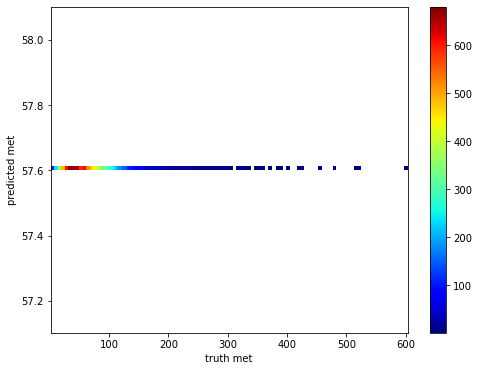

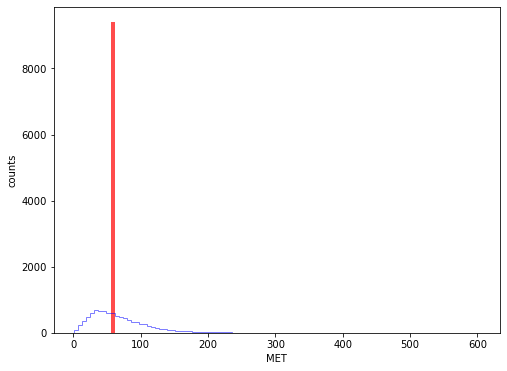

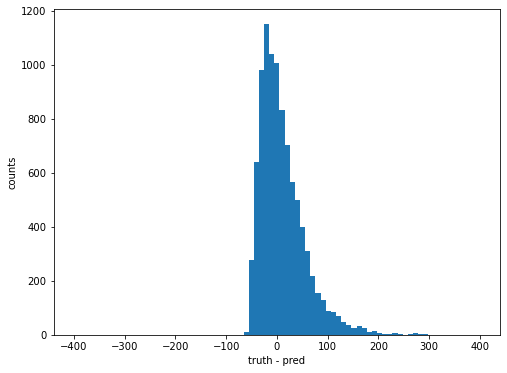

In [40]:
test_model(model, x_test, y_test, output_path="train_cnn/predict")

In [46]:
data = [y_predict.flatten(),y_test]
wandb.log({"MET": wandb.Histogram(data)})

In [43]:
data.shape

AttributeError: 'list' object has no attribute 'shape'